In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import os
from tqdm.auto import tqdm
import cv2
from glob import glob
import numpy as np
import pandas as pd
import PIL
import urllib
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader
import torch
from torchvision.utils import make_grid
from torch.optim import Adam,RMSprop
import torch.utils as utils
import torch.nn.init as init
import torchvision.utils as v_utils
import torchvision.transforms as transforms

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Dec 14 13:20:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/drive', force_remount=True)

unset HISTFILE; export PS1="root@6039c6974236-bfe1133a02074b77bf377421e83af38f: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@6039c6974236-bfe1133a02074b77bf377421e83af38f: umount -f /content/drive || umount /content/drive; pkill -9 -x drive
umount: /content/drive: no mount point specified.
umount: /content/drive: no mount point specified.
root@6039c6974236-bfe1133a02074b77bf377421e83af38f: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@6039c6974236-bfe1133a02074b77bf377421e83af38f: ( while `sleep 0.5`; do if [[ -d "/content/drive" && "$(ls -A /content/drive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 147
root@6039c6974236-bfe1133a02074b77bf377421e83af38f: cat /tmp/tmpll0fc9vj/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_instances:1

In [4]:
os.chdir('./drive/MyDrive/2021_deep/')

In [5]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
device

'cuda'

In [6]:
## hyper parmeter
img_size = 256
in_dim = 3
out_dim = 3
num_filters = 72
batch_size = 2
lr = 0.0005
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x_dir, y_dir,transform=None):
        super().__init__()
        self.transforms = transform
        self.x_img = x_dir
        self.y_img = y_dir   

    def __len__(self):
        return len(self.x_img)

    def __getitem__(self, idx):
        x_img = self.x_img[idx]
        y_img = self.y_img[idx]
        # Read an image with OpenCV
        x_img = cv2.imread(x_img)
        y_img =cv2.imread(y_img)
# #         print(x_img)
        x_img= cv2.cvtColor(x_img, cv2.COLOR_BGR2RGB)
        y_img= cv2.cvtColor(y_img, cv2.COLOR_BGR2RGB)

        sample = {'image': x_img, 'labeled': y_img}
        if self.transforms:
            augmented = self.transforms(image=x_img,target_image=y_img)
            image = augmented['image']
            labeled = augmented['target_image']

            
            image=np.transpose(image,(2,0,1))
            labeled=np.transpose(labeled,(2,0,1))

        return image, labeled 

In [8]:
# data_path_folder=sorted(os.listdir("./train/")) 
# label_path_folder=sorted(os.listdir("./label/"))

data_path_folder = sorted(glob(f'./train/*.jpg'))
label_path_folder = sorted(glob(f'./label/*.jpg'))

In [9]:
len(data_path_folder),len(label_path_folder)

(351, 351)

In [10]:
# import random

# random.shuffle(data_path_folder)
# random.shuffle(label_path_folder)

In [11]:

import albumentations.pytorch


aug = albumentations.Compose([ 
      albumentations.Resize(img_size, img_size),
      # albumentations.OneOf([
                          # albumentations.HorizontalFlip(p=0.3),
                          # albumentations.RandomRotate90(p=0.3),
                          # albumentations.VerticalFlip(p=0.3)            
            # ], p=0.3),
            # albumentations.OneOf([
            #               albumentations.MotionBlur(p=1),
            #               # albumentations.ToGray(p=1)                 
            # ], p=0.1),         
      # albumentations.pytorch.transforms.ToTensor(),
      albumentations.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
      ], additional_targets={'target_image':'image'})


In [12]:


train_dataset = MyDataset(data_path_folder,label_path_folder,transform=aug)
train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 256, 256)


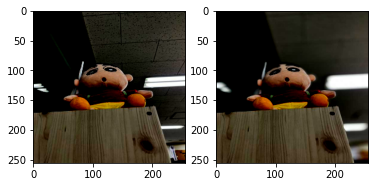

In [13]:
images,labels = next(iter(train_dataloader))
x=images[0].numpy()
# print(x)
y=torch.squeeze(labels[0])
y=y.numpy()
print(y.shape)
plt.subplot(1,2,1)
plt.imshow(x.transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(y.transpose((1,2,0)))
plt.show()

In [14]:
# tensor로 구성된 이미지를 화면에 띄워주는 함수를 구성합니다.(이미지 시각화)
def show_tensor_images(image_tensor1,image_tensor2,image_tensor3,image_tensor4, num_images=batch_size, size=(3, 512, 512)):
    '''
    image_tensor: 텐서로 구성된 이미지
    num_images: 이미지 개수
    size: 이미지 크기
    -> 이미지를 화면에 보여줍니다.
    '''
    image_tensor1 = (image_tensor1 + 1) / 2
    image_unflat1 = image_tensor1.detach().cpu()
    image_grid1 = make_grid(image_unflat1[:num_images], nrow=5)

    image_tensor2 = (image_tensor2 + 1) / 2
    image_unflat2 = image_tensor2.detach().cpu()
    image_grid2 = make_grid(image_unflat2[:num_images], nrow=5)

    image_tensor3 = (image_tensor3 + 1) / 2
    image_unflat3 = image_tensor3.detach().cpu()
    image_grid3 = make_grid(image_unflat3[:num_images], nrow=5)

    image_tensor4 = (image_tensor4 + 1) / 2
    image_unflat4 = image_tensor4.detach().cpu()
    image_grid4 = make_grid(image_unflat4[:num_images], nrow=5)

    plt.figure(figsize=(16,18))
    plt.subplot(4,2,1)
    plt.imshow(image_grid1.permute(1, 2, 0).squeeze())
    plt.subplot(4,2,2)
    plt.imshow(image_grid2.permute(1, 2, 0).squeeze())
    plt.subplot(4,2,3)
    plt.imshow(image_grid3.permute(1, 2, 0).squeeze())
    plt.subplot(4,2,4)
    plt.imshow(image_grid4.permute(1, 2, 0).squeeze())
    plt.show()

In [15]:
def conv_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn
    )
    return model 

def conv_trans_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=3, stride=2, padding=1,output_padding =1),
        nn.BatchNorm2d(out_dim),
        act_fn
    )
    return model 

def maxpool():
    pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
    return pool

def conv_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model 

class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]

        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels)),

        layers.append(nn.LeakyReLU(0.2))

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.down = nn.Sequential(*layers)

    def forward(self, x):
        x = self.down(x)
        return x
        
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels,4,2,1,bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU()
        ]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.up = nn.Sequential(*layers)

    def forward(self,x,skip):
        x = self.up(x)
        x = torch.cat((x,skip),1)
        return x
        

In [16]:
class Generator_b2n(nn.Module):
    
    def __init__(self,in_dim,out_dim,num_filter):
        super(Generator_b2n,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        print("\n------Initiating U-Net------\n")

        self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn)
        self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn)
        self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
        self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
        self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
        self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)

        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter,self.out_dim,3,1,1),
            nn.Tanh(),  #필수는 아님
            # nn.Sigmoid(),  #필수는 아님
        )

    def forward(self,input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1,down_4],dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2,down_3],dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3,down_2],dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4,down_1],dim=1)
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out

In [17]:

# # generator: 가짜 이미지를 생성합니다.
# class GeneratorUNet(nn.Module):
#     def __init__(self, in_channels=3, out_channels=3):
#         super().__init__()

#         self.down1 = UNetDown(in_channels, 64, normalize=False)
#         self.down2 = UNetDown(64,128)                 
#         self.down3 = UNetDown(128,256)               
#         self.down4 = UNetDown(256,512,dropout=0.5) 
#         self.down5 = UNetDown(512,512,dropout=0.5)      
#         self.down6 = UNetDown(512,512,dropout=0.5)             
#         self.down7 = UNetDown(512,512,dropout=0.5)              
#         self.down8 = UNetDown(512,512,normalize=False,dropout=0.5)

#         self.up1 = UNetUp(512,512,dropout=0.5)
#         self.up2 = UNetUp(1024,512,dropout=0.5)
#         self.up3 = UNetUp(1024,512,dropout=0.5)
#         self.up4 = UNetUp(1024,512,dropout=0.5)
#         self.up5 = UNetUp(1024,256)
#         self.up6 = UNetUp(512,128)
#         self.up7 = UNetUp(256,64)
#         self.up8 = nn.Sequential(
#             nn.ConvTranspose2d(128,3,4,stride=2,padding=1),
#             nn.Tanh()
#         )

#     def forward(self, x):
#         d1 = self.down1(x)
#         d2 = self.down2(d1)
#         d3 = self.down3(d2)
#         d4 = self.down4(d3)
#         d5 = self.down5(d4)
#         d6 = self.down6(d5)
#         d7 = self.down7(d6)
#         d8 = self.down8(d7)

#         u1 = self.up1(d8,d7)
#         u2 = self.up2(u1,d6)
#         u3 = self.up3(u2,d5)
#         u4 = self.up4(u3,d4)
#         u5 = self.up5(u4,d3)
#         u6 = self.up6(u5,d2)
#         u7 = self.up7(u6,d1)
#         u8 = self.up8(u7)

#         return u8

In [18]:
class Discriminator_n(nn.Module):

    def __init__(self, im_chan=3, hidden_dim=4):
        super(Discriminator_n, self).__init__()
        
        # Discriminator모델 구성하기
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),  #32
            self.make_disc_block(hidden_dim, hidden_dim * 2),  # 32, 64
            self.make_disc_block(hidden_dim*2, hidden_dim * 4, stride=1), # 64. 128
            self.make_disc_block(hidden_dim*4, hidden_dim * 8, stride=2), #128,128
            self.make_disc_block(hidden_dim * 8, 1, final_layer=True),  # 128,1
        )

    # 위의 모델 아키텍쳐 사진과 같이 block 구성
    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        disc_pred = self.disc(image)  # discriminator의 판별 결과 (0:fake, 1:real)
        return disc_pred.view(len(disc_pred), -1)

In [19]:
class Generator_n2b(nn.Module):
    
    def __init__(self,in_dim,out_dim,num_filter):
        super(Generator_n2b,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        print("\n------Initiating U-Net------\n")

        self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn)
        self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn)
        self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
        self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
        self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
        self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)

        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter,self.out_dim,3,1,1),
            nn.Tanh(),  #필수는 아님
            # nn.Sigmoid(),  #필수는 아님
        )

    def forward(self,input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1,down_4],dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2,down_3],dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3,down_2],dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4,down_1],dim=1)
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out

In [60]:
class Discriminator_b(nn.Module):

    def __init__(self, im_chan=3, hidden_dim=4):
        super(Discriminator_b, self).__init__()
        
        # Discriminator모델 구성하기
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),  #32
            self.make_disc_block(hidden_dim, hidden_dim * 2),  # 32, 64
            self.make_disc_block(hidden_dim*2, hidden_dim * 4, stride=1), # 64. 128
            self.make_disc_block(hidden_dim*4, hidden_dim * 8, stride=2), #128,128
            self.make_disc_block(hidden_dim * 8, 1, final_layer=True),  # 128,1
        )

    # 위의 모델 아키텍쳐 사진과 같이 block 구성
    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        disc_pred = self.disc(image)  # discriminator의 판별 결과 (0:fake, 1:real)
        return disc_pred.view(len(disc_pred), -1)

In [61]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [62]:
# 생성한 G, D model GPU로 보내기
gen_b2n = Generator_b2n(in_dim=in_dim,out_dim=out_dim,num_filter=num_filters).to(device)
disc_n = Discriminator_n(hidden_dim=64).to(device)
gen_n2b = Generator_n2b(in_dim=in_dim,out_dim=out_dim,num_filter=num_filters).to(device)
disc_b = Discriminator_b(hidden_dim=64).to(device)

# # optimizer 지정하기
# gen_optimizer_b2n = Adam(gen_b2n.parameters(), lr, betas=(beta_1, beta_2))
# disc_optimizer_n = Adam(disc_n.parameters(), lr, betas=(beta_1, beta_2))
# gen_optimizer_n2b = Adam(gen_n2b.parameters(), lr, betas=(beta_1, beta_2))
# disc_optimizer_b = Adam(disc_b.parameters(), lr, betas=(beta_1, beta_2))

# optimizer 지정하기
gen_optimizer_b2n = RMSprop(gen_b2n.parameters(), lr)
disc_optimizer_n = RMSprop(disc_n.parameters(), lr)
gen_optimizer_n2b = RMSprop(gen_n2b.parameters(), lr)
disc_optimizer_b = RMSprop(disc_b.parameters(), lr)

# 위에서 정의한 weights_init 함수를 통해 가중치 초기화하기
#gen_b2n = gen_b2n.apply(weights_init)
#disc_n = disc_n.apply(weights_init)
#gen_n2b = gen_n2b.apply(weights_init)
#disc_b = disc_b.apply(weights_init)


criterion = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss = Sigmoid layer + BCELoss
display_step = 500
L1 = nn.L1Loss()
n_epochs = 9302
cur_step = 0
none_generator_loss = 0
none_discriminator_loss = 0
back_generator_loss = 0
back_discriminator_loss = 0
lamd = 10.0
cnt =0
generator_total_loss = torch.zeros(5*n_epochs*int(len(label_path_folder)/batch_size)+1)
generator_local_loss = torch.zeros(n_epochs*int(len(label_path_folder)/batch_size)+1)


# for wgan parmeters 
n_critic = 5
clip = 0.01
cnt_gen_iter = 0


------Initiating U-Net------


------Initiating U-Net------



In [63]:

def disloss(logits_fake,logits_real):
  disc_loss = (-torch.mean(logits_real)+torch.mean(logits_fake))   # discriminator의 최종 loss
  return disc_loss



In [64]:
# gen_n2b.train()
# gen_b2n.train()
# disc_b.train()
# disc_n.train()
# for epoch in tqdm(range(n_epochs)):
#     # print(f'epoch: {epoch+1}/{n_epochs}')
#     for none,back in train_dataloader:
#         none = none.to(device).float()
#         back = back.to(device).float()
        
#         '''
#         Discriminator 업데이트
#         '''
#         disc_optimizer_n.zero_grad()  # 최적화된 모든 변수 초기화
#         disc_optimizer_b.zero_grad()
        

#         # back 2 none
#         fake_none = gen_b2n(back)
#         logits_fake_none = disc_n(fake_none.detach())
#         logits_real_none = disc_n(none)
#         # [Discriminator Loss] 
#         dis_none_loss = disloss(logits_fake_none,logits_real_none)
#         none_discriminator_loss += (dis_none_loss.item() / display_step)  # epoch별 Discriminator 평균 loss
#         dis_none_loss.backward(retain_graph=True)
#         disc_optimizer_n.step()

#         # none 2 back
#         fake_back = gen_n2b(none)
#         logits_fake_back = disc_b(fake_back.detach())
#         logits_real_back = disc_b(back)
#         # [Discriminator Loss] 
#         dis_back_loss = disloss(logits_fake_back,logits_real_back)
#         back_discriminator_loss += (dis_back_loss.item() / display_step)  # epoch별 Discriminator 평균 loss
#         dis_back_loss.backward(retain_graph=True)
#         disc_optimizer_b.step()


#         # dis_total_loss = dis_none_loss+dis_back_loss
#         # dis_total_loss.backward(retain_graph=True)
#         # disc_optimizer_n.step()
#         # disc_optimizer_b.step()

#         # Clip weights of discriminator //참고함.
#         for p in disc_n.parameters():
#             p.data.clamp_(-clip, clip)
#         for g in disc_b.parameters():
#             g.data.clamp_(-clip,clip)


#         '''
#         Generator 업데이트
#         '''

#         # Train the generator every n_critic iterations
#         if cur_step % n_critic == 0:

#           gen_optimizer_b2n.zero_grad()  # 최적화된 모든 변수 초기화
#           gen_optimizer_n2b.zero_grad()

#           # back 2 none
#           fake_none_re = gen_b2n(back)
#           fake_back = gen_n2b(fake_none_re)
#           cycle_loss1 = L1(back,fake_back)*lamd
#           identity_back = gen_b2n(back)
#           identity_loss1 = L1(back,identity_back)*0.5*lamd

#           # none 2 back
#           fake_back_re = gen_n2b(none)
#           fake_none = gen_b2n(fake_back_re)
#           cycle_loss2 = L1(none,fake_none)*lamd
#           identity_none = gen_n2b(none)
#           identity_loss2 = L1(none,identity_none)*0.5*lamd

#           # Generator Loss
#           # gen_none_loss=criterion(disc_n(fake_none_re), torch.ones_like(disc_n(fake_none_re)))
#           # gen_back_loss=criterion(disc_b(fake_back_re), torch.ones_like(disc_b(fake_back_re)))
#           gen_none_loss = -torch.mean(disc_n(fake_none_re))
#           gen_back_loss = -torch.mean(disc_b(fake_back_re))


#           none_generator_loss += (gen_none_loss.item() / (display_step/n_critic))  # epoch별 Generator 평균 loss
#           back_generator_loss += (gen_back_loss.item() / (display_step/n_critic))  # epoch별 Generator 평균 loss
#           generator_total_loss[cnt_gen_iter] = (gen_none_loss.item() + gen_back_loss.item() )/2.0
#           cnt_gen_iter +=1

#           gan_loss = gen_none_loss + gen_back_loss + cycle_loss1 + cycle_loss2 + identity_loss1 + identity_loss2

#           gan_loss.backward(retain_graph=True)

#           gen_optimizer_b2n.step()
#           gen_optimizer_n2b.step()

#         ## Visualization code ##
#         if cur_step % display_step == 0 or cur_step == 0 or epoch == n_epochs:
#             print(f"Step {cur_step}: Gen_none loss: {none_generator_loss},Gen_back loss: {back_generator_loss}, disc_none loss: {none_discriminator_loss}, disc_back loss: {back_discriminator_loss}, Cycle Loss: {gan_loss}")
#             show_tensor_images(fake_back_re,none,fake_none,fake_none_re)   # generator로 생성한 이미지 화면에 나타내기
#             plt.plot(generator_total_loss[:cnt_gen_iter+100])
#             plt.show()
#             none_generator_loss = 0
#             none_discriminator_loss = 0
#             back_generator_loss = 0
#             back_discriminator_loss = 0
#         cur_step += 1
      
#     torch.save(gen_b2n.state_dict(), 'gen_b2n.pt')
#     torch.save(gen_n2b.state_dict(), 'gen_n2b.pt')
#     torch.save(disc_b.state_dict(), 'disc_b.pt')
#     torch.save(disc_n.state_dict(), 'disc_n.pt')
#     # if epoch %100 == 0: 
#     #   plt.plot(generator_total_loss[:cnt+100])
#     #   plt.show()


In [ ]:
gen_n2b.train()
gen_b2n.train()
disc_b.train()
disc_n.train()
dis_cnt = 0
for epoch in tqdm(range(n_epochs)):
    # print(f'epoch: {epoch+1}/{n_epochs}')
    for none,back in train_dataloader:
        none = none.to(device)
        back = back.to(device)
        
        '''
        Discriminator 업데이트
        '''
        for k in range(n_critic):
          disc_optimizer_n.zero_grad()  # 최적화된 모든 변수 초기화
          disc_optimizer_b.zero_grad()
          
          # back 2 none
          fake_none = gen_b2n(back)
          logits_fake_none = disc_n(fake_none.detach())
          logits_real_none = disc_n(none)
          # [Discriminator Loss] 
          dis_none_loss = disloss(logits_fake_none,logits_real_none)
          none_discriminator_loss += (dis_none_loss.item() / (display_step*n_critic))  # epoch별 Discriminator 평균 loss
          dis_none_loss.backward(retain_graph=True)
          disc_optimizer_n.step()

          # none 2 back
          fake_back = gen_n2b(none)
          logits_fake_back = disc_b(fake_back.detach())
          logits_real_back = disc_b(back)
          # [Discriminator Loss] 
          dis_back_loss = disloss(logits_fake_back,logits_real_back)
          back_discriminator_loss += (dis_back_loss.item() / (display_step*n_critic))  # epoch별 Discriminator 평균 loss

          generator_total_loss[dis_cnt] = -(dis_back_loss.item() +dis_none_loss.item())/2
          dis_cnt+=1
          dis_back_loss.backward(retain_graph=True)
          disc_optimizer_b.step()

          # Clip weights of discriminator //참고함.
          for p in disc_n.parameters():
              p.data.clamp_(-clip, clip)
          for g in disc_b.parameters():
              g.data.clamp_(-clip,clip)


        '''
        Generator 업데이트
        '''
        gen_optimizer_b2n.zero_grad()  # 최적화된 모든 변수 초기화
        gen_optimizer_n2b.zero_grad()

        # back 2 none
        fake_none_re = gen_b2n(back)
        fake_back = gen_n2b(fake_none_re)
        cycle_loss1 = L1(back,fake_back)*lamd
        identity_back = gen_b2n(back)
        identity_loss1 = L1(back,identity_back)*0.5*lamd

        # none 2 back
        fake_back_re = gen_n2b(none)
        fake_none = gen_b2n(fake_back_re)
        cycle_loss2 = L1(none,fake_none)*lamd
        identity_none = gen_n2b(none)
        identity_loss2 = L1(none,identity_none)*0.5*lamd

        # Generator Loss
        # gen_none_loss=criterion(disc_n(fake_none_re), torch.ones_like(disc_n(fake_none_re)))
        # gen_back_loss=criterion(disc_b(fake_back_re), torch.ones_like(disc_b(fake_back_re)))
        gen_none_loss = -torch.mean(disc_n(fake_none_re))
        gen_back_loss = -torch.mean(disc_b(fake_back_re))

        generator_local_loss[cnt_gen_iter] = (gen_none_loss.item() +gen_back_loss.item() )/2

        none_generator_loss += (gen_none_loss.item() / (display_step))  # epoch별 Generator 평균 loss
        back_generator_loss += (gen_back_loss.item() / (display_step))  # epoch별 Generator 평균 loss
        

        gan_loss = gen_none_loss + gen_back_loss + cycle_loss1 + cycle_loss2 + identity_loss1 + identity_loss2
        cnt_gen_iter +=1

        gan_loss.backward(retain_graph=True)

        gen_optimizer_b2n.step()
        gen_optimizer_n2b.step()

        ## Visualization code ##
        if cur_step % display_step == 0 or cur_step == 0 or epoch == n_epochs:
            print(f"Step {cur_step}: Gen_none loss: {none_generator_loss},Gen_back loss: {back_generator_loss}, disc_none loss: {none_discriminator_loss}, disc_back loss: {back_discriminator_loss}, Cycle Loss: {gan_loss}")
            show_tensor_images(fake_back_re,none,fake_none,fake_none_re)   # generator로 생성한 이미지 화면에 나타내기
            
            plt.plot(generator_total_loss[:dis_cnt+100])
            plt.show()
            plt.plot(generator_local_loss[:cnt_gen_iter+100])
            plt.show()
            none_generator_loss = 0
            none_discriminator_loss = 0
            back_generator_loss = 0
            back_discriminator_loss = 0
            torch.save(gen_b2n.state_dict(), 'gen_b2n.pt')
            torch.save(gen_n2b.state_dict(), 'gen_n2b.pt')
            torch.save(disc_b.state_dict(), 'disc_b.pt')
            torch.save(disc_n.state_dict(), 'disc_n.pt')
            tmp =[]
            for m in disc_b.modules():
                if isinstance(m, nn.Conv2d):
                  tmp.append(np.array(m.weight.data.detach().cpu().flatten()))
            for m in disc_n.modules():
                if isinstance(m, nn.Conv2d):
                  tmp.append(np.array(m.weight.data.detach().cpu().flatten()))
            plt.hist(tmp, bins=200, histtype='stepfilled')
            plt.show()

        cur_step += 1
      

    # if epoch %100 == 0: 
    #   plt.plot(generator_total_loss[:cnt+100])
    #   plt.show()



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
sum([param.nelement() for param in model.parameters()])

In [ ]:
#Loss
plt.plot(generator_total_loss)

In [ ]:
import torch.nn as nn
import torch
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [ ]:
def conv_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn
    )
    return model 

def conv_trans_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=3, stride=2, padding=1,output_padding =1),
        nn.BatchNorm2d(out_dim),
        act_fn
    )
    return model 

def maxpool():
    pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
    return pool

def conv_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model 

In [ ]:
class Unet(nn.Module):
    def __init__(self,in_dim,out_dim,num_filter):
        super(Unet,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        print("\n------Initiating U-Net------\n")

        self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn)
        self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn)
        self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
        self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
        self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
        self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)

        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter,self.out_dim,3,1,1),
            # nn.Tanh(),  #필수는 아님
        )

    def forward(self,input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1,down_4],dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2,down_3],dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3,down_2],dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4,down_1],dim=1)
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out

In [ ]:
import math
def rmse_score(true, pred):
    score = math.sqrt(np.mean((true-pred)**2))
    return score

def psnr_score(true, pred, pixel_max):
    score = 20*np.log10(pixel_max/rmse_score(true, pred))
    return score

In [ ]:
model = Unet(in_dim=in_dim,out_dim=out_dim,num_filter=num_filters)
model.to(device)
sum([param.nelement() for param in model.parameters()])

In [ ]:
import torch.optim as optim
# optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=6)
criterion = nn.L1Loss()


In [ ]:
# #model

model.to(device)
model.load_state_dict(torch.load('deep_1.pt'))

In [ ]:
from tqdm.auto import tqdm

n_epochs=99999999

valid_loss_min = np.Inf
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

model.to(device)

for e in np.arange(n_epochs):
  print('Starting epoch = ', e)

    # Training
  model.train()
  for data,labels in tqdm(train_dataloader):
    
    labels=np.transpose(labels,(0,3,1,2))
    labels = labels /255

    # print(data.shape)
    # print(labels.shape)
    data = data.to(device=device).float()
    labels = labels.to(device=device).float()

    optimizer.zero_grad()
    logits = model(data)
    
    # print(logits)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()
    train_loss[e] += loss.item()

  train_loss[e] /= len(train_dataloader)
  if e % 50 == 0:
    x=data.detach().cpu().numpy()*255
    y=labels.detach().cpu().numpy()*255
    z=logits.detach().cpu().numpy()*255

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.imshow(x[0].transpose((1,2,0))/255)
    plt.title('input_img', fontsize=10)
    plt.subplot(1,3,2)
    plt.imshow(z[0].transpose((1,2,0))/255)
    plt.title('output_img', fontsize=10)
    plt.subplot(1,3,3)
    plt.imshow(y[0].transpose((1,2,0))/255)
    plt.title('target_img', fontsize=10)
    plt.show()
    print('input PSNR :', psnr_score(x.astype(float), y.astype(float), 512))
    print('output PSNR :', psnr_score(z[0].astype(float), y.astype(float), 512), '\n')


  # plt.imshow(y.transpose((1,2,0)))
  # plt.show()

# print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} '.format(e, train_loss[e]))
  # result = predict(data_path_folder[:1], 64,1)

  # for i, (input_path, label_path) in enumerate(zip(data_path_folder[:1], label_path_folder[:1])):
  #   input_img = cv2.imread(input_path)
  #   input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
  #   targ_img = cv2.imread(label_path)
  #   targ_img = cv2.cvtColor(targ_img, cv2.COLOR_BGR2RGB)
  #   pred_img = result[0]
  #   pred_img=np.transpose(pred_img,(1,2,0))
  #   # pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

  #   plt.figure(figsize=(20,10))
  #   plt.subplot(1,3,1)
  #   plt.imshow(input_img)
  #   plt.title('input_img', fontsize=10)
  #   plt.subplot(1,3,2)
  #   plt.imshow(pred_img)
  #   plt.title('output_img', fontsize=10)
  #   plt.subplot(1,3,3)
  #   plt.imshow(targ_img)
  #   plt.title('target_img', fontsize=10)
  #   plt.show()
  #   print('input PSNR :', psnr_score(input_img.astype(float), targ_img.astype(float), 512))
  #   print('output PSNR :', psnr_score(pred_img[i].astype(float), targ_img.astype(float), 512), '\n')

  torch.save(model.state_dict(), 'deep_1.pt')


In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.plot(valid_loss)